In [1]:
%%capture
import fsspec
import json
import pandas as pd
from datetime import datetime
import networkx as nx
from matplotlib.pyplot import figure
from swifttokens import *
%set_env OS_STORAGE_URL={OS_STORAGE_URL}
%set_env OS_AUTH_TOKEN={OS_AUTH_TOKEN}
import panel as pn
pn.extension()

In [2]:
panelplt=pn.pane.Matplotlib(figure(figsize=(16, 9))).servable() #needtobedone for serving

<Figure size 1600x900 with 0 Axes>

In [3]:
link="https://swift.dkrz.de/v1/dkrz_7fa6baba-db43-4d12-a295-8e3ebb1a01ed/data_transfer/eerie_data-transfer_network.json"
with fsspec.open(link,"r") as f:
    ntjsonin=json.load(f)
df_first=pd.DataFrame(ntjsonin["network_transfer"])

In [4]:
ploturl="swift://swift.dkrz.de/dkrz_7fa6baba-db43-4d12-a295-8e3ebb1a01ed/data_transfer/network.png"

In [5]:
G = nx.from_pandas_edgelist(df_first, 'Host', 'Destination')
G = nx.DiGraph(G)
#G = nx.grid_2d_graph(6, 6)
#G = nx.house_graph(G)
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
#pos = graphviz_layout(G, prog='dot', root=0)
pos = nx.spring_layout(G)

#get edge_labels and alingment:
edge_labels={}
verticalalignment={}

for no,line in df_first.iterrows():
    edge_labels[(line["Host"],line["Destination"])]=f"{line['Date']}\n{line['Speed']}"
    verticalalignment[(line["Host"],line["Destination"])]=line["verticalalignment"]

#remove wrong edges
for edge in [
    a 
    for a in G.edges
    if a not in edge_labels.keys()
] :
    G.remove_edge(edge[0],edge[1])

#plot config
colormap=[]
widthmap=[]

for node in G.nodes:
    inst=node.split('\n')[0]
    st=node.split('\n')[1]
    colormap.append(ntjsonin["network_plot_config"]["Colors"][inst])
    widthmap.append(ntjsonin["network_plot_config"]["Storage size"][node])
    
widthmap=[(int(a)/100)*10000
          for a in widthmap
         ]

In [6]:
def plot_network(df):
    now = datetime.now()

    plt=figure(figsize=(16, 9))
    plt.suptitle(now.strftime("%d/%m/%Y %H:%M:%S"))
    #
    #Plot

    nx.draw(
        G,
        pos,
        with_labels=True,
        font_size=18,
        arrows=True,
        node_color=colormap,
        edge_color=list(df_first["Status"]),
        node_size=widthmap,
        arrowstyle='-|>',
        arrowsize=14,
        connectionstyle='arc3, rad = 0.15'
    )
    for edge in G.edges:
        nx.draw_networkx_edge_labels(G, 
                                     pos,
                                     edge_labels={
                                         k : v
                                         for k,v in edge_labels.items()
                                         if k == edge
                                     },
                                     font_size=12,
                                     verticalalignment=verticalalignment[edge]
                                )
    panelplt.object=plt
    panelplt.param.trigger('object')
    with fsspec.open(ploturl,"wb") as f:
        plt.savefig(f, dpi=100)

In [7]:
example=pd.DataFrame([{"Host":[],"Destination":[],"Status":[],"Date":[],"Speed":[],"verticalalignment":[]}])
def read_df(**kwargs):
    with fsspec.open(link,"r") as f:
        ntjsonin=json.load(f)
    return pd.DataFrame(ntjsonin["network_transfer"])

In [8]:
from streamz.dataframe import PeriodicDataFrame
df = PeriodicDataFrame(read_df,example=example,interval='60s',filename="test.csv")

In [9]:
df.stream.sink(plot_network)

'<sink: plot_network>'

Matplotlib(Figure, height=648, width=1152)
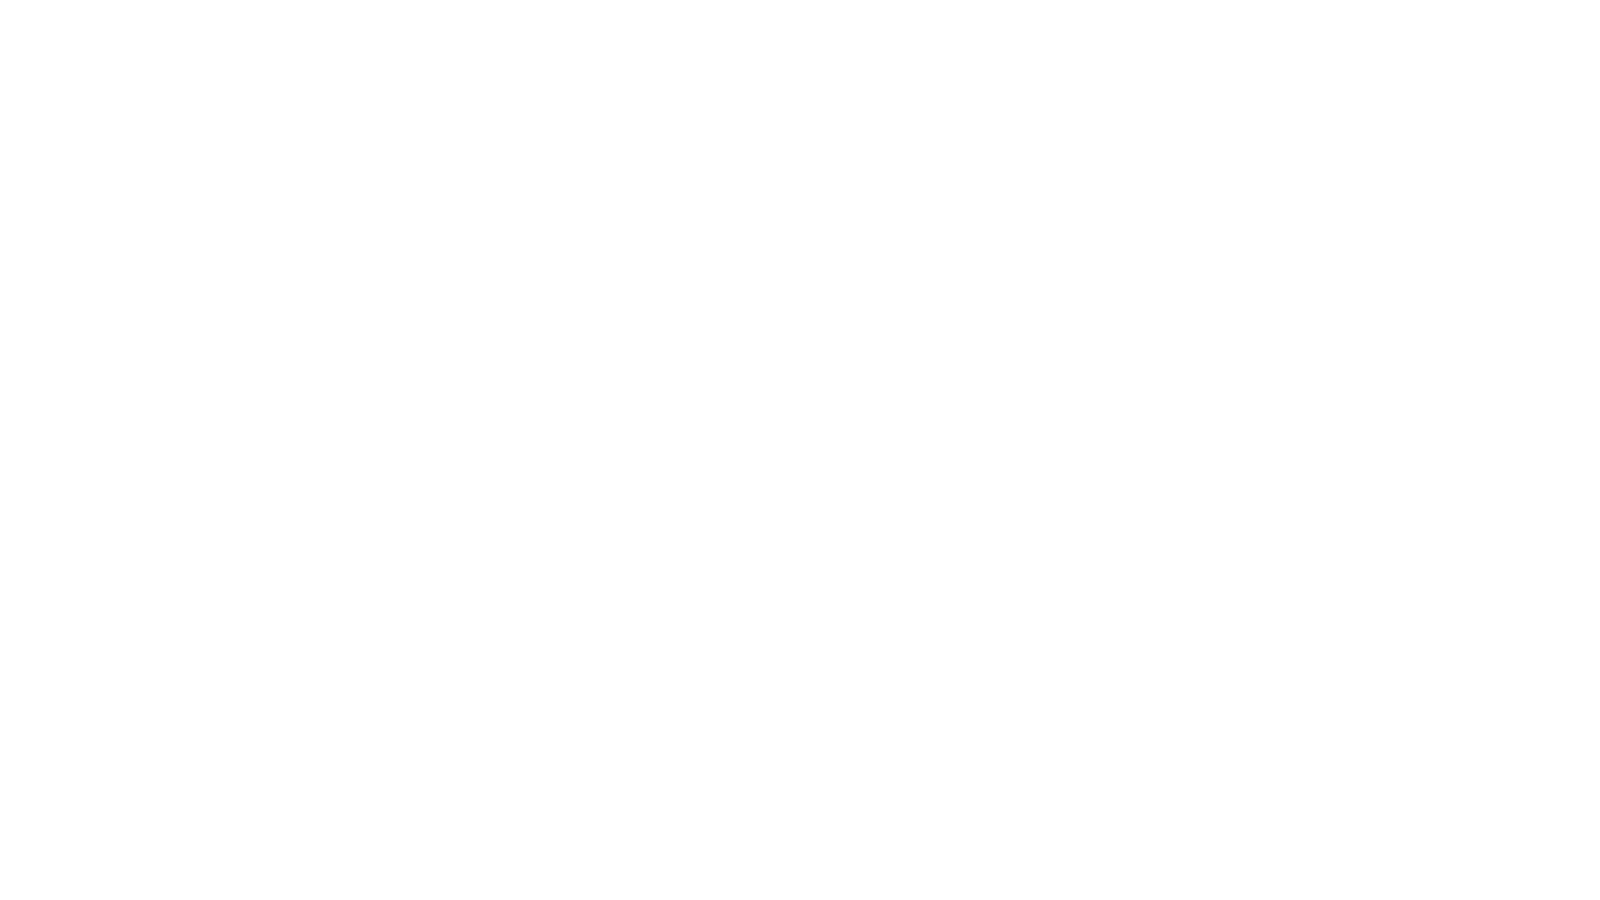

In [10]:
panelplt